In [17]:
!nvidia-smi

Sun Jan 11 05:47:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             29W /   70W |    2804MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
!pip install -q gdown inference-gpu

In [19]:
!git clone https://github.com/nguyenhoangviethung/football_tracking.git

fatal: destination path 'football_tracking' already exists and is not an empty directory.


In [20]:
%cd football_tracking
!git pull
%cd ..

/content/football_tracking
Already up to date.
/content


In [21]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /content/0bfacc_0.mp4
100% 19.9M/19.9M [00:00<00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
To: /content/2e57b9_0.mp4
100% 21.1M/21.1M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
To: /content/08fd33_0.mp4
100% 19.9M/19.9M [00:00<00:00, 284MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
To: /content/573e61_0.mp4
100% 18.9M/18.9M [00:00<00:00, 123MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu
To: /content/121364_0.mp4
100% 17.2M/17.2M [00:00<00:00, 160MB/s]


In [22]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [23]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc-0hfgb/1"
BALL_DETECION_MODEL_ID='football-ball-detection-rejhg/4'
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
BALL_DETECTION_MODEL = get_model(model_id=BALL_DETECION_MODEL_ID, api_key=ROBOFLOW_API_KEY)


Resolved model_id: football-players-detection-3zvbc-0hfgb/1, dataset_id: football-players-detection-3zvbc-0hfgb, version_id: 1
Resolved model_id: football-ball-detection-rejhg/4, dataset_id: football-ball-detection-rejhg, version_id: 4


In [24]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

Resolved model_id: football-field-detection-f07vi/14, dataset_id: football-field-detection-f07vi, version_id: 14


In [25]:
import sys
import os

path_to_project = "/content/football_tracking"
if path_to_project not in sys.path:
    sys.path.append(path_to_project)

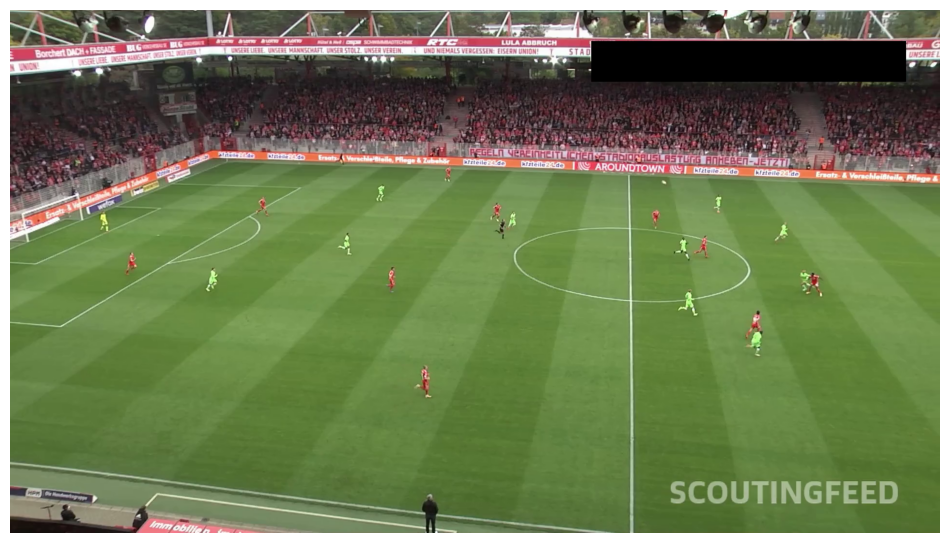

In [26]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [27]:
import supervision as sv
from tqdm import tqdm
from football_tracking.common.team import TeamClassifier
import torch # Import torch to check for CUDA availability

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

# Dynamically set device to 'cuda' if available, otherwise 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
team_classifier = TeamClassifier(device=device)
team_classifier.fit(crops)

collecting crops: 25it [00:13,  1.85it/s]


Using device: cuda


In [28]:
from football_tracking.common.track import FootballTracker
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/output_tracked.mp4"
tracker_system = FootballTracker(
    team_classifier=team_classifier,
    player_model=PLAYER_DETECTION_MODEL,
    ball_model=BALL_DETECTION_MODEL,
    player_id=2,
    gk_id=1,
    ball_id=0,
    reclassify_interval=30,
    kit_timeout=60
)

# print(f"--- Giai đoạn: Tracking & Gán số áo ---")
# tracker_system.process_video(
#     source_path=SOURCE_VIDEO_PATH,
#     target_path=TARGET_VIDEO_PATH
# )
# print(f"Thành công! Video đã được lưu tại: {TARGET_VIDEO_PATH}")

In [29]:
!ls

08fd33_0.mp4  121364_0.mp4  573e61_0.mp4       sample_data
0bfacc_0.mp4  2e57b9_0.mp4  football_tracking


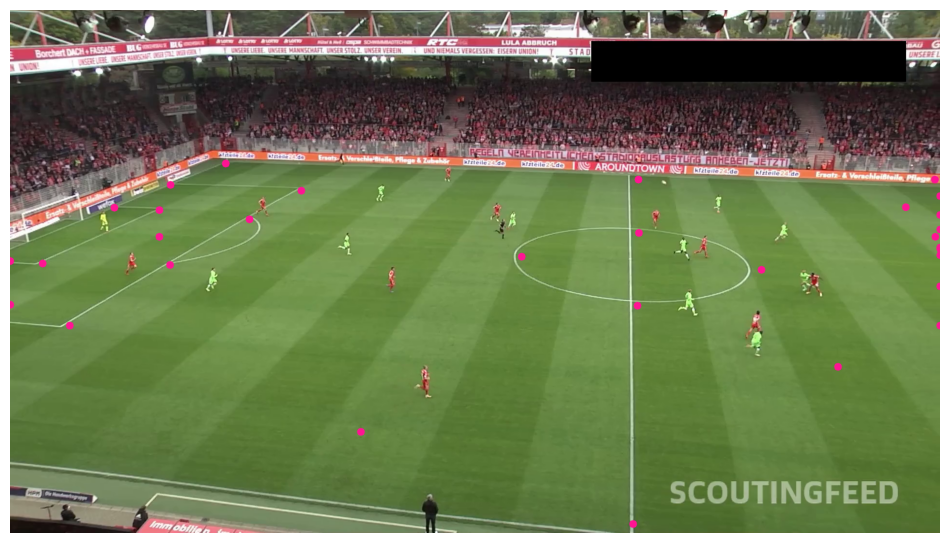

In [30]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

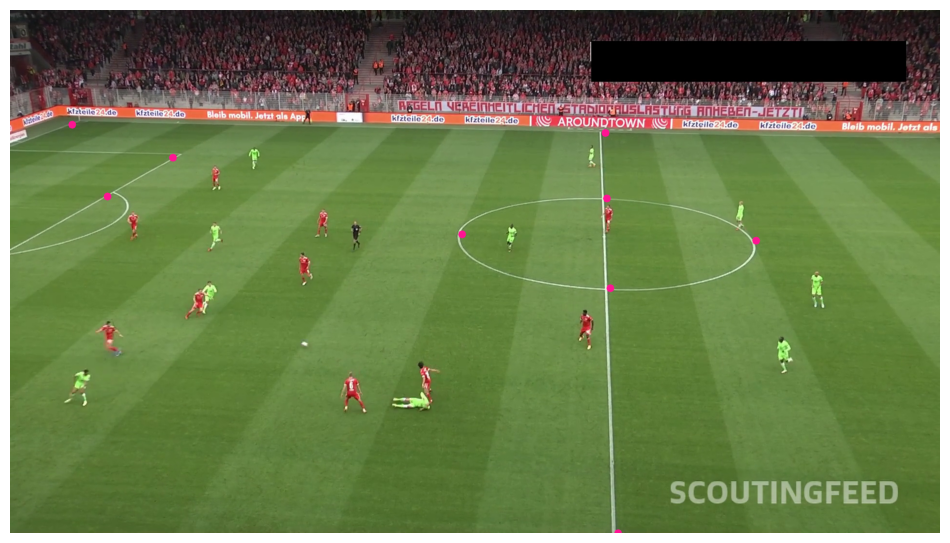

In [31]:
import supervision as sv
import numpy as np
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

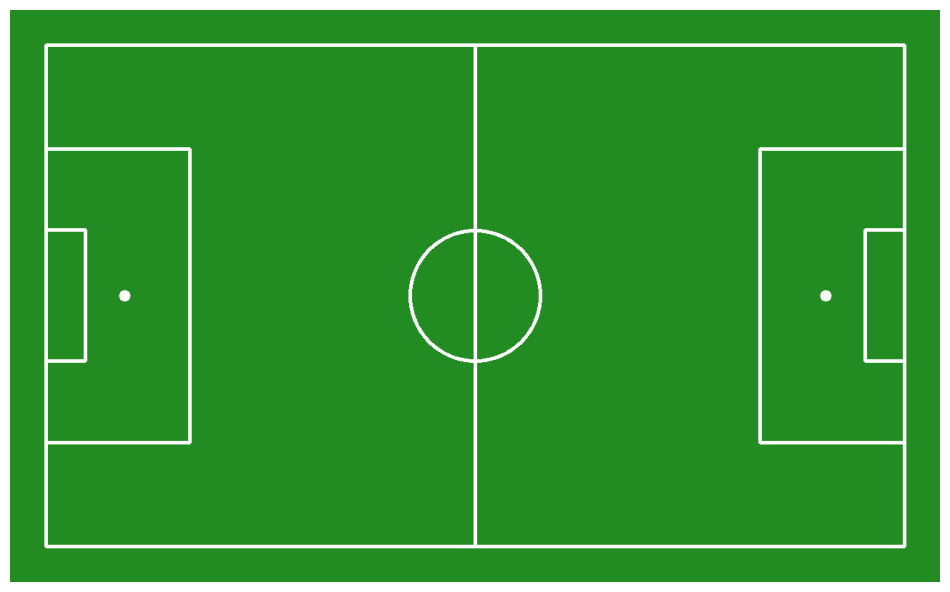

In [32]:

from football_tracking.annotators.soccer import draw_pitch
from football_tracking.configs.config import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

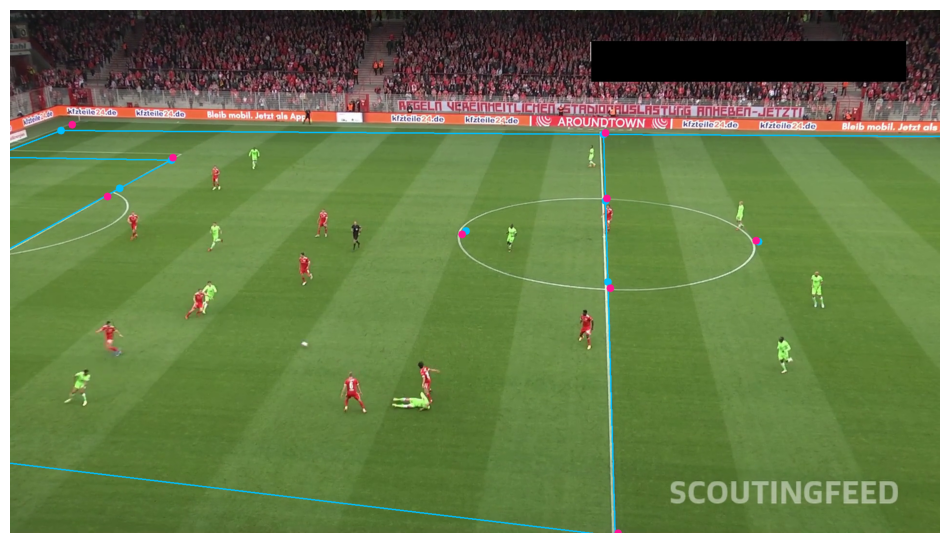

In [33]:
import numpy as np
import supervision as sv
from football_tracking.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [34]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

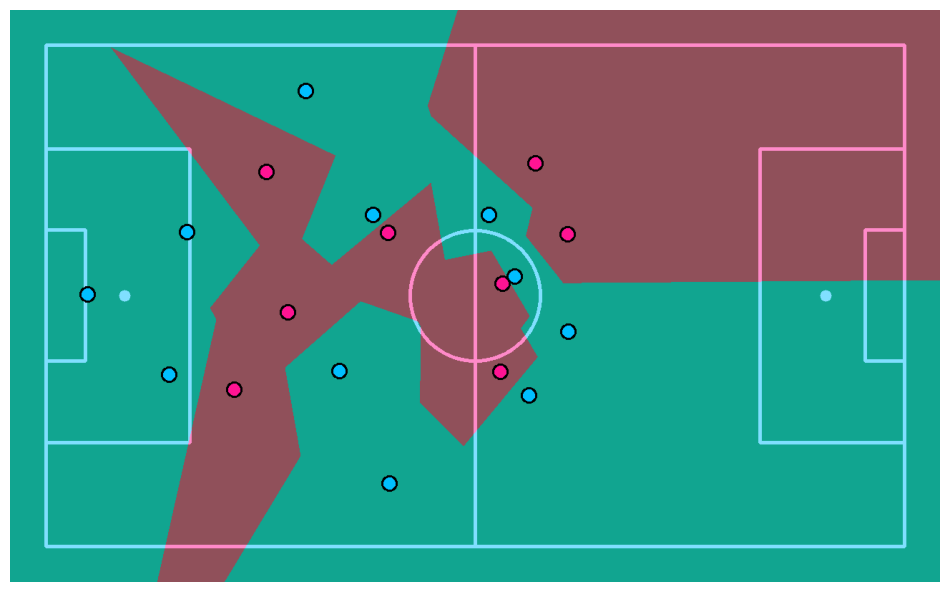

In [35]:
import supervision as sv
from football_tracking.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CONFIG = SoccerPitchConfiguration()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

p_res = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(p_res)

mask = np.isin(detections.class_id, [tracker_system.PLAYER_ID, tracker_system.GOALKEEPER_ID])
detections = detections[mask]

tracked_people = tracker_system.global_tracker.update_with_detections(detections)
# 2. Team & Kit Number Assignment (Sử dụng bộ nhớ cache của tracker_system)
# Bước này thay thế hoàn toàn phần "team assignment" thủ công của bạn
unknown_crops, unknown_indices = [], []
for i, (tid, cid) in enumerate(zip(tracked_people.tracker_id, tracked_people.class_id)):
    if cid == tracker_system.PLAYER_ID:
        if tid not in tracker_system.team_cache:
            unknown_crops.append(sv.crop_image(frame, tracked_people.xyxy[i]))
            unknown_indices.append(i)

if unknown_crops:
    new_teams = team_classifier.predict(unknown_crops)
    for u_idx, nt_id in zip(unknown_indices, new_teams):
        tid = tracked_people.tracker_id[u_idx]
        tracker_system.team_cache[tid] = nt_id

# Chuẩn bị labels và class_id cuối cùng
final_labels = []
final_class_ids = []
for i, (tid, cid) in enumerate(zip(tracked_people.tracker_id, tracked_people.class_id)):
    if cid == tracker_system.PLAYER_ID:
        t_id = tracker_system.team_cache.get(tid, 0)
        # Cấp số áo thông minh 1-10
        k_num = tracker_system._assign_kit_number(tid, t_id, 0)
        final_class_ids.append(t_id)
        final_labels.append(f"#{k_num}")
    else:
        final_class_ids.append(-1) # Chờ resolve GK
        final_labels.append("GK")

tracked_people.class_id = np.array(final_class_ids)

# Resolve GK và Merge (Sử dụng helper từ team_classifier)
gk_mask = (tracked_people.class_id == -1)
if np.any(gk_mask):
    gk_team_ids = team_classifier.resolve_goalkeepers_team_id(
        tracked_people[tracked_people.class_id != -1], tracked_people[gk_mask])
    tracked_people.class_id[gk_mask] = gk_team_ids

# --- B. RADAR & VORONOI VIEW ---

# 1. Xử lý Ball Tracking
b_res = BALL_DETECTION_MODEL.infer(frame, confidence=0.25)[0]
ball_dets = sv.Detections.from_inference(b_res)
tracked_ball = tracker_system.ball_tracker.update_with_detections(ball_dets[ball_dets.class_id == 0])

# 2. Homography (View Transformer)
f_res = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
kpts = sv.KeyPoints.from_inference(f_res)
kpt_filter = kpts.confidence[0] > 0.5
transformer = ViewTransformer(source=kpts.xy[0][kpt_filter], target=np.array(CONFIG.vertices)[kpt_filter])

pitch_ball_xy = transformer.transform_points(tracked_ball.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))
pitch_people_xy = transformer.transform_points(tracked_people.get_anchors_coordinates(sv.Position.BOTTOM_CENTER))

# 3. Visualization
# Radar View
radar_view = draw_pitch(CONFIG)
t0_xy = pitch_people_xy[tracked_people.class_id == 0]
t1_xy = pitch_people_xy[tracked_people.class_id == 1]

# Vẽ Voronoi
if len(t0_xy) > 0 and len(t1_xy) > 0:
    radar_view = draw_pitch_voronoi_diagram(
        config=CONFIG, team_1_xy=t0_xy, team_2_xy=t1_xy,
        team_1_color=sv.Color.from_hex('00BFFF'), team_2_color=sv.Color.from_hex('FF1493'),
        pitch=radar_view
    )

# Vẽ cầu thủ lên Radar
radar_view = draw_points_on_pitch(CONFIG, t0_xy, face_color=sv.Color.from_hex('00BFFF'), pitch=radar_view)
radar_view = draw_points_on_pitch(CONFIG, t1_xy, face_color=sv.Color.from_hex('FF1493'), pitch=radar_view)

sv.plot_image(radar_view)

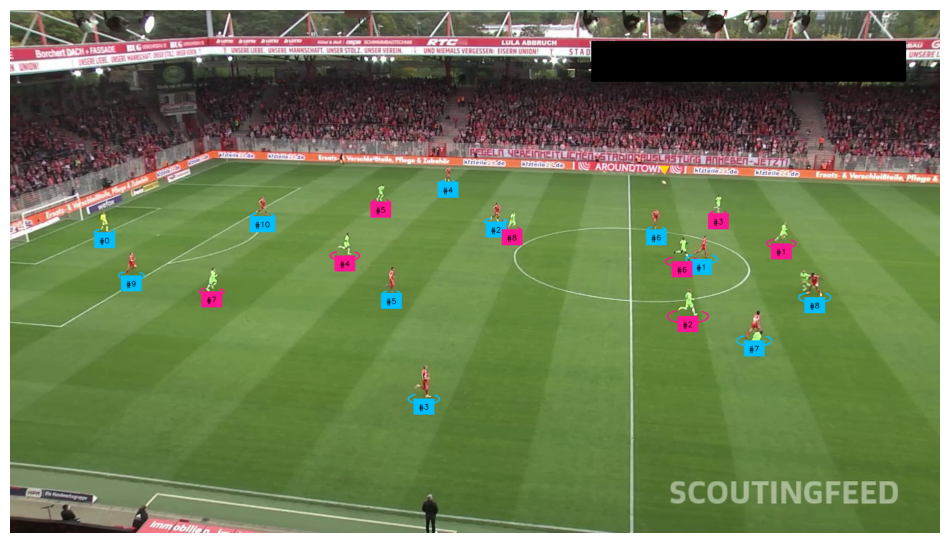

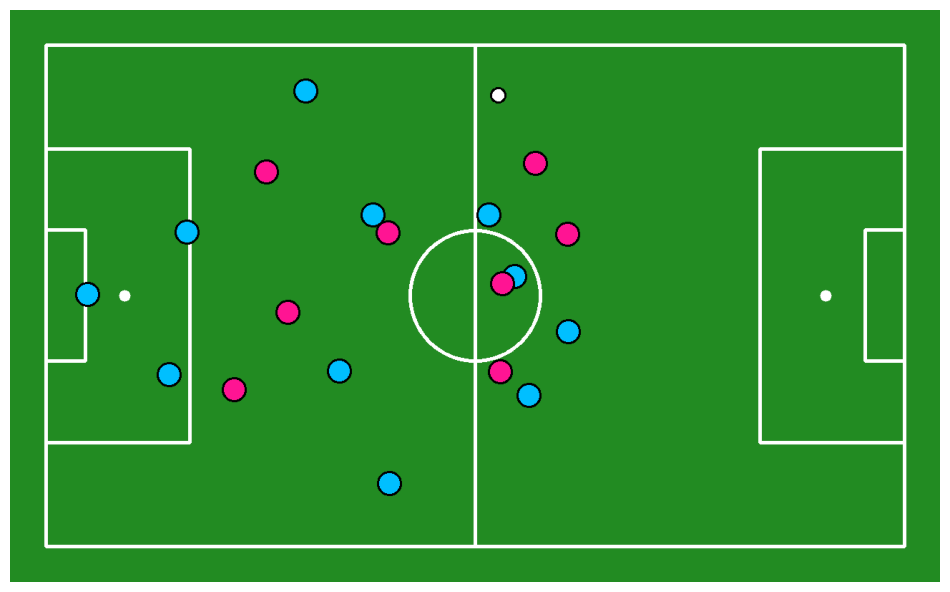

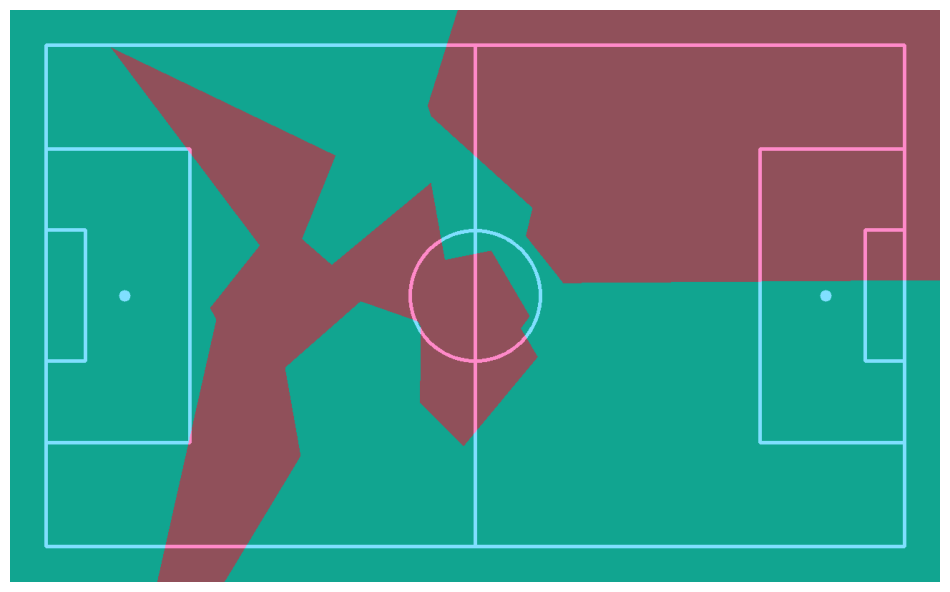

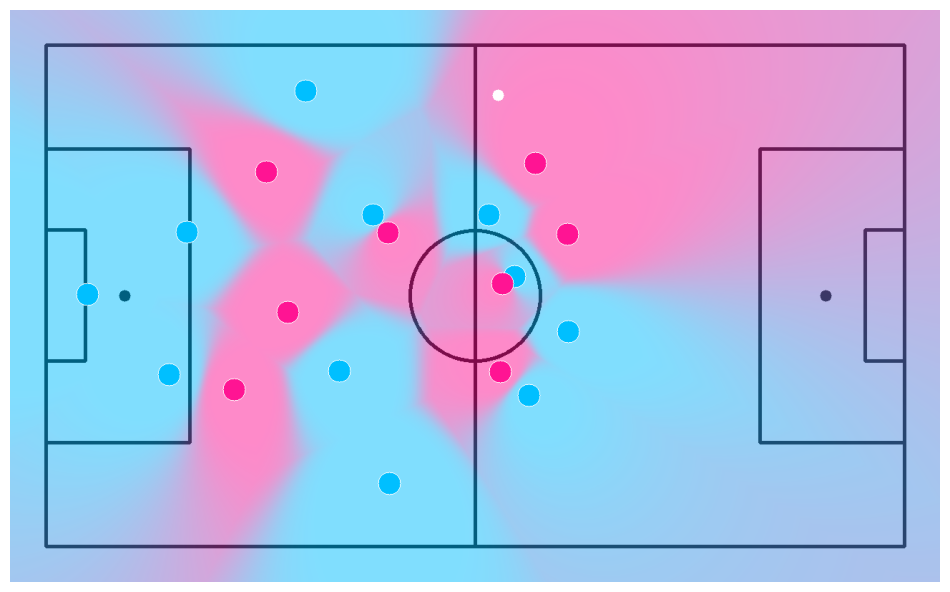

In [36]:
import numpy as np
import supervision as sv
from football_tracking.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = tracker_system

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.global_tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

gk_tracker_ids = set(goalkeepers_detections.tracker_id)

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = team_classifier.resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = []
current_frame_idx = 0

for tracker_id, class_id in zip(all_detections.tracker_id, all_detections.class_id):
    if tracker_id in gk_tracker_ids:
        labels.append("#0")
    elif class_id in [0, 1]:
        kit_number = tracker._assign_kit_number(tracker_id, int(class_id), current_frame_idx)
        labels.append(f"#{kit_number}")
    else:
        labels.append("REF")

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

annotated_frame = draw_pitch(CONFIG)

team_1_players_xy = pitch_players_xy[players_detections.class_id == 0]
team_2_players_xy = pitch_players_xy[players_detections.class_id == 1]

if len(team_1_players_xy) > 0 and len(team_2_players_xy) > 0:
    annotated_frame = draw_pitch_voronoi_diagram(
        config=CONFIG,
        team_1_xy=team_1_players_xy,
        team_2_xy=team_2_players_xy,
        team_1_color=sv.Color.from_hex('00BFFF'),
        team_2_color=sv.Color.from_hex('FF1493'),
        pitch=annotated_frame)
else:
    print("Skipping Voronoi diagram visualization: Not enough players for both teams.")

sv.plot_image(annotated_frame)

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)

if len(team_1_players_xy) > 0 and len(team_2_players_xy) > 0:
    annotated_frame = draw_pitch_voronoi_diagram_2(
        config=CONFIG,
        team_1_xy=team_1_players_xy,
        team_2_xy=team_2_players_xy,
        team_1_color=sv.Color.from_hex('00BFFF'),
        team_2_color=sv.Color.from_hex('FF1493'),
        pitch=annotated_frame)
else:
    print("Skipping blended Voronoi diagram visualization: Not enough players for both teams.")

annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [37]:
from collections import deque
import supervision as sv
from football_tracking.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

100%|██████████| 750/750 [01:33<00:00,  8.04it/s]


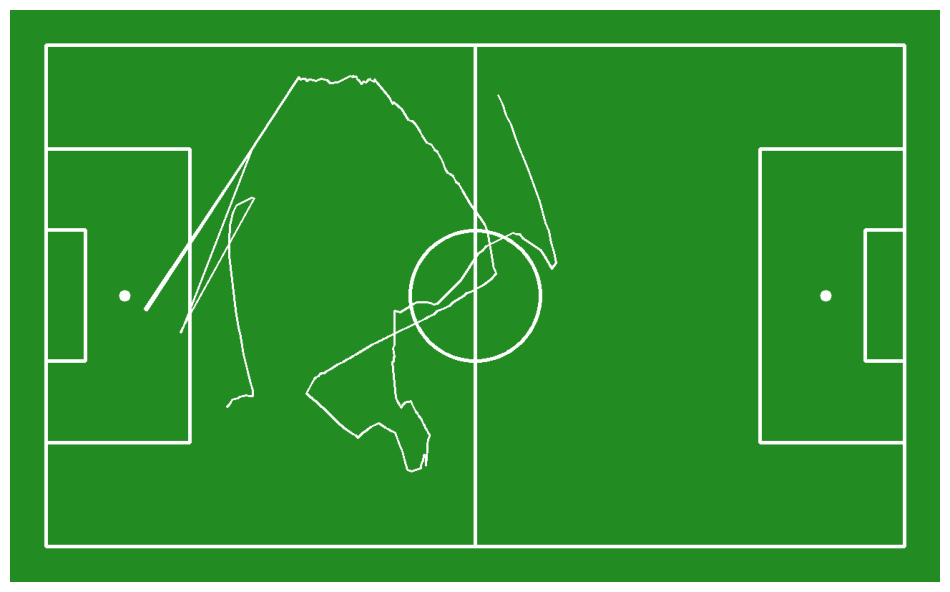

In [38]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]
from football_tracking.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [39]:
# import cv2
# import numpy as np
# import supervision as sv
# from tqdm import tqdm

# # Import các thành phần từ GitHub của bạn
# from football_tracking.common.track import FootballTracker
# from football_tracking.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram
# from football_tracking.configs.config import SoccerPitchConfiguration

# # --- SỬA LỖI Ở ĐÂY: ViewTransformer dùng findHomography ---
# class ViewTransformer:
#     def __init__(self, source: np.ndarray, target: np.ndarray):
#         source = source.astype(np.float32)
#         target = target.astype(np.float32)
#         # SỬA LỖI: Dùng findHomography để xử lý trường hợp có > 4 điểm
#         # getPerspectiveTransform chỉ chạy được khi có đúng 4 điểm
#         self.m, _ = cv2.findHomography(source, target)

#     def transform_points(self, points: np.ndarray) -> np.ndarray:
#         # Nếu không tính được ma trận hoặc không có điểm nào cần transform
#         if points.size == 0 or self.m is None:
#             return points

#         reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
#         transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
#         return transformed_points.reshape(-1, 2)

# # --- Class Kế thừa giữ nguyên logic Tracking ---
# class FootballTrackerWithHologram(FootballTracker):
#     def process_video(self, source_path, target_path, config=SoccerPitchConfiguration()):
#         video_info = sv.VideoInfo.from_video_path(source_path)
#         frame_generator = sv.get_video_frames_generator(source_path)

#         writer = cv2.VideoWriter(
#             target_path,
#             cv2.VideoWriter_fourcc(*'mp4v'),
#             video_info.fps,
#             video_info.resolution_wh
#         )

#         print(f"Bắt đầu xử lý (Tracking chuẩn + Hologram)...")

#         for idx, frame in enumerate(tqdm(frame_generator, total=video_info.total_frames)):
#             # ==========================================================
#             # 1. LOGIC TRACKING GỐC
#             # ==========================================================
#             # A. Detection
#             p_res = self.player_model.infer(frame, confidence=0.3)[0]
#             detections = sv.Detections.from_inference(p_res)
#             mask = np.isin(detections.class_id, [self.PLAYER_ID, self.GOALKEEPER_ID])
#             detections = detections[mask]

#             tracked = self.global_tracker.update_with_detections(detections)

#             # B. Team Classification
#             should_reclassify = (idx % self.reclassify_interval == 0)
#             unknown_crops, unknown_idxs = [], []

#             for i, (tid, cid) in enumerate(zip(tracked.tracker_id, tracked.class_id)):
#                 if cid == self.PLAYER_ID:
#                     if tid not in self.team_cache or should_reclassify:
#                         unknown_crops.append(sv.crop_image(frame, tracked.xyxy[i]))
#                         unknown_idxs.append(i)

#             if unknown_crops:
#                 new_teams = self.team_classifier.predict(unknown_crops)
#                 for u_idx, nt_id in zip(unknown_idxs, new_teams):
#                     tid = tracked.tracker_id[u_idx]
#                     if self.team_cache.get(tid) is not None and self.team_cache.get(tid) != nt_id:
#                         self.kit_number_cache.pop(tid, None)
#                     self.team_cache[tid] = nt_id

#             # C. Attributes
#             final_cids, final_labels, p_xy, p_team = [], [], [], []
#             for i, (tid, cid) in enumerate(zip(tracked.tracker_id, tracked.class_id)):
#                 if cid == self.PLAYER_ID:
#                     t_id = self.team_cache.get(tid, 0)
#                     k_num = self._assign_kit_number(tid, t_id, idx)
#                     final_cids.append(t_id)
#                     final_labels.append(f"#{k_num}")
#                     p_xy.append(tracked.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)[i])
#                     p_team.append(t_id)
#                 else:
#                     final_cids.append(-1)
#                     final_labels.append("GK")

#             tracked.class_id = np.array(final_cids)

#             # D. Resolve GK
#             gk_mask = (tracked.class_id == -1)
#             gk_indices = np.where(gk_mask)[0] # Lưu index để dùng cho logic resolve

#             # E. Ball
#             b_res = self.ball_model.infer(frame, confidence=0.25)[0]
#             ball_det = sv.Detections.from_inference(b_res)

#             # Xử lý tương thích ngược tên biến ball tracker
#             if hasattr(self, 'ball_byte_tracker'):
#                 ball_tracked = self.ball_byte_tracker.update_with_detections(ball_det[ball_det.class_id == self.BALL_ID])
#             else:
#                 ball_tracked = self.ball_tracker.update_with_detections(ball_det[ball_det.class_id == self.BALL_ID])

#             if hasattr(self, 'ball_smoother'):
#                 ball_tracked = self.ball_smoother.update(ball_tracked)

#             # ==========================================================
#             # 2. LOGIC HOLOGRAM
#             # ==========================================================
#             f_res = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
#             kpts = sv.KeyPoints.from_inference(f_res)
#             kpt_filter = kpts.confidence[0] > 0.5

#             has_homography = False
#             pitch_people_xy = np.empty((0, 2))
#             pitch_ball_xy = np.empty((0, 2))

#             # Chỉ chạy khi có >= 4 điểm
#             if np.sum(kpt_filter) >= 4:
#                 transformer = ViewTransformer(
#                     source=kpts.xy[0][kpt_filter],
#                     target=np.array(config.vertices)[kpt_filter]
#                 )

#                 if transformer.m is not None:
#                     # Transform People
#                     people_xy_all = tracked.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
#                     pitch_people_xy = transformer.transform_points(people_xy_all)

#                     # Transform Ball
#                     if len(ball_tracked) > 0:
#                         ball_xy_all = ball_tracked.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
#                         pitch_ball_xy = transformer.transform_points(ball_xy_all)

#                     has_homography = True

#             # Resolve GK Logic (Moved here to use Homography distance if available)
#             if np.any(gk_mask) and len(p_xy) > 0:
#                 # Nếu có homography, dùng khoảng cách trên sân 2D (chính xác hơn)
#                 if has_homography and len(pitch_people_xy) > 0:
#                     coords = pitch_people_xy
#                 else:
#                     # Fallback dùng toạ độ pixel
#                     coords = np.array(p_xy)

#                 # Tính lại mask cho team dựa trên danh sách tracked hiện tại (đã cập nhật class_id ở trên chưa?)
#                 # class_id hiện tại của player đã là 0 hoặc 1. GK là -1.
#                 t0_mask = tracked.class_id == 0
#                 t1_mask = tracked.class_id == 1

#                 c0 = coords[t0_mask].mean(axis=0) if np.any(t0_mask) else np.array([-9999, -9999])
#                 c1 = coords[t1_mask].mean(axis=0) if np.any(t1_mask) else np.array([9999, 9999])

#                 for g_idx in gk_indices:
#                     g_xy = coords[g_idx]
#                     tracked.class_id[g_idx] = 0 if np.linalg.norm(g_xy-c0) < np.linalg.norm(g_xy-c1) else 1

#             # ==========================================================
#             # 3. RENDERING
#             # ==========================================================
#             annotated = frame.copy()

#             # Vẽ Main Frame
#             # Tách GK và Player để vẽ đúng màu/box
#             # Lúc này class_id của GK đã được resolve thành 0 hoặc 1
#             # Ta cần dùng labels để biết ai là GK ("GK")

#             # Tạo mask logic từ labels
#             is_gk_bool = np.array([l == "GK" for l in final_labels])

#             # Ball (Vẽ dưới cùng)
#             if hasattr(self, 'ball_annotator'):
#                 annotated = self.ball_annotator.annotate(annotated, ball_tracked)

#             # Players (Không phải GK)
#             annotated = self.player_annotator.annotate(annotated, tracked[~is_gk_bool])
#             annotated = self.player_label_annotator.annotate(annotated, tracked[~is_gk_bool],
#                                                              [l for l, g in zip(final_labels, is_gk_bool) if not g])

#             # GK (Vẽ Box)
#             annotated = self.gk_box_annotator.annotate(annotated, tracked[is_gk_bool])
#             annotated = self.player_label_annotator.annotate(annotated, tracked[is_gk_bool],
#                                                              ["GK"]*sum(is_gk_bool))

#             if hasattr(self, 'ball_marker') and len(ball_tracked) > 0:
#                 annotated = self.ball_marker.annotate(annotated, ball_tracked)

#             # Vẽ Hologram Overlay
#             if has_homography:
#                 radar_view = draw_pitch(config)

#                 t0_xy = pitch_people_xy[tracked.class_id == 0]
#                 t1_xy = pitch_people_xy[tracked.class_id == 1]

#                 if len(t0_xy) >= 2 and len(t1_xy) >= 2:
#                     radar_view = draw_pitch_voronoi_diagram(
#                         config=config, team_1_xy=t0_xy, team_2_xy=t1_xy,
#                         team_1_color=sv.Color.from_hex('#00BFFF'), team_2_color=sv.Color.from_hex('#FF1493'),
#                         opacity=0.6, pitch=radar_view
#                     )

#                 radar_view = draw_points_on_pitch(config, t0_xy, face_color=sv.Color.from_hex('#00BFFF'), radius=10, pitch=radar_view)
#                 radar_view = draw_points_on_pitch(config, t1_xy, face_color=sv.Color.from_hex('#FF1493'), radius=10, pitch=radar_view)
#                 radar_view = draw_points_on_pitch(config, pitch_ball_xy, face_color=sv.Color.WHITE, radius=8, pitch=radar_view)

#                 target_h = int(annotated.shape[0] * 0.3)
#                 scale = target_h / radar_view.shape[0]
#                 target_w = int(radar_view.shape[1] * scale)

#                 radar_resized = cv2.resize(radar_view, (target_w, target_h))

#                 margin = 20
#                 y1 = annotated.shape[0] - target_h - margin
#                 y2 = annotated.shape[0] - margin
#                 x1 = annotated.shape[1] - target_w - margin
#                 x2 = annotated.shape[1] - margin

#                 annotated[y1:y2, x1:x2] = radar_resized
#                 cv2.rectangle(annotated, (x1, y1), (x2, y2), (255, 255, 255), 2)

#             writer.write(annotated)

#         writer.release()

# # ==========================================
# # CHẠY LẠI
# # ==========================================
# SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
# TARGET_VIDEO_PATH = "/content/output_tracked_final_fixed.mp4"

# # Khởi tạo lại tracker với class mới đã fix lỗi ViewTransformer
# tracker_with_hologram = FootballTrackerWithHologram(
#     team_classifier=team_classifier,
#     player_model=PLAYER_DETECTION_MODEL,
#     ball_model=BALL_DETECTION_MODEL,
#     player_id=2, gk_id=1, ball_id=0,
#     reclassify_interval=30, kit_timeout=60
# )

# print("--- Giai đoạn: Tracking (Chuẩn) + Hologram (Fixed) ---")
# tracker_with_hologram.process_video(
#     source_path=SOURCE_VIDEO_PATH,
#     target_path=TARGET_VIDEO_PATH
# )
# print(f"Thành công! Video đã được lưu tại: {TARGET_VIDEO_PATH}")

In [40]:
# Import module (nếu bạn đã push code mới lên github và pull về)
from football_tracking.common.track2 import FootballTracker
from football_tracking.configs.config import SoccerPitchConfiguration

# Cấu hình đường dẫn
SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
TARGET_VIDEO_PATH = "/content/output_tracked_hologram_final.mp4"

# 1. Khởi tạo Tracker với đầy đủ 4 models (quan trọng nhất là field_model)
tracker_system = FootballTracker(
    team_classifier=team_classifier,      # Object đã được .fit() từ các bước trước
    player_model=PLAYER_DETECTION_MODEL,
    ball_model=BALL_DETECTION_MODEL,
    field_model=FIELD_DETECTION_MODEL,    # <--- BẮT BUỘC: Model sân để tính Homography
    player_id=2,
    gk_id=1,
    ball_id=0,
    reclassify_interval=30,               # 1 giây check lại đội 1 lần
    kit_timeout=60                        # 2 giây mất dấu thì xóa số áo
)

# 2. Chạy xử lý video với Hologram (Picture-in-Picture)
print(f"--- Bắt đầu xử lý: Tracking chuẩn + Hologram Overlay ---")
tracker_system.process_video_with_hologram(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    config=SoccerPitchConfiguration()
)

print(f"Xử lý thành công! Video lưu tại: {TARGET_VIDEO_PATH}")

--- Bắt đầu xử lý: Tracking chuẩn + Hologram Overlay ---


100%|██████████| 750/750 [07:09<00:00,  1.74it/s]

Xử lý thành công! Video lưu tại: /content/output_tracked_hologram_final.mp4
